In [1]:
import numpy as np
import argparse
import dlib
import glob
import os
from PIL import Image
from matplotlib import pyplot as plt
import cv2
import imgaug.augmenters as iaa
import scipy.io
import tensorflow as tf
import math

In [2]:
data_dir = "MPIIGaze/Data/Normalized"
list_ds = tf.data.Dataset.list_files(str(data_dir+'/*/*'))
data = []
labels = []
def norm(kek):
    return math.sqrt(kek @ kek)
counter = 0
for strs in list_ds:
    print(counter)
    counter += 1
    pic_address = strs.numpy().decode("utf-8").split("/")
    pic_address[2] = "Original"
    pic_address[4] = pic_address[4][0:5]
    pic_address.append("annotation.txt")
    pic_address = os.path.join(*pic_address)
    with open(pic_address) as f:
        annotations = f.readlines()
    mat = scipy.io.loadmat(strs.numpy())
    for picnum in range(len(mat['data'][0][0][0][0][0][1])):
        annotation = annotations[picnum]
        annotation = annotation.split(" ")
        annotation = np.array(annotation, dtype=np.float32)
        eye_coords = [annotation[38:41], annotation[35:38]]
        view_target = annotation[26:29]
        rotation = annotation[29:32]
        rotation, _ = cv2.Rodrigues(rotation)
        rotation = np.linalg.inv(rotation)
        for i in range(2):
            img = mat['data'][0][0][i][0][0][1][picnum]
            img = Image.fromarray(img)
            img = np.array(img)
            img = img.reshape((36, 60, 1))
            data.append(img / 255) 
            vect = eye_coords[i] - view_target
            vect = rotation @ vect
            vect /= norm(vect)
            labels.append(vect)

print("ready")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

mat['data'][0][0][0][0][0][0] some 3d vector <br>
mat['data'][0][0][0][0][0][1] eyes maybe <br>
mat['data'][0][0][0][0][0][2] some 3d vector


mat['data'][0][0][eye_num] eye num

In [3]:
"""data = tf.data.Dataset.from_tensor_slices(data)
labels = tf.data.Dataset.from_tensor_slices(labels)"""

data = np.array(data)
labels = np.array(labels)
labels.shape

(427312, 3)

import copy
from functools import partial
def get_pixel(tens, a, b, c, d,
              width=0.54, heigth=0.30375,
              pixel_width=1920, pixel_heigth=1080):
    [x, y, z] = tens
    k = -d / (a * x + b * y + c * z)
    x = k * x
    y = k * y
    z = k * z
    pixel_x = x / width * pixel_width
    pixel_y = y / heigth * pixel_heigth
    return pixel_x, pixel_y
pxlf = partial(get_pixel,a=0, b=0, c=1, d=-1)
xlist, ylist = [], []
for img in labels:
    x, y = pxlf(img)
    xlist.append(x)
    ylist.append(y)

sns.jointplot(x=xlist, y=ylist, kind="hex", color="k");

In [4]:
"""dataset = tf.data.Dataset.zip((data, labels))"""
NUM_BATCHES = 32
def generatorr(data, labels):
    order_list = np.arange(len(data) )
    order_list = np.random.permutation(order_list)
    affine = iaa.Affine(scale=(0.95,1.05), translate_percent=(-0.05,0.05),)
    noise = iaa.Sequential([
        iaa.Sometimes(then_list=iaa.AdditiveGaussianNoise(scale=(0, 0.03), per_channel=True)),
      #  iaa.Sometimes(then_list=iaa.AdditivePoissonNoise(lam=(0, 1), per_channel=True)),
        #iaa.Sometimes(then_list=iaa.SaltAndPepper(p=(0,0.1)))
    ])
    blur = iaa.OneOf([
        #iaa.GaussianBlur(sigma=(0.2, 0.6)),
    ])
    augmentation = iaa.Sequential([blur, noise, affine])
    augmented_list = []
    augmented_lavels = []

    for i in range(len(order_list) - 4 * NUM_BATCHES):
        if len(augmented_list) == 0:
            augmented_list = [np.ndarray.astype(data[order_list[i+j]], dtype=np.float32) for j in range(NUM_BATCHES)]

            augmented_labels = [labels[order_list[i+j]] for j in range(NUM_BATCHES)]
            
            augmented_list = augmentation.augment_images(augmented_list)
            
        pic = augmented_list[0]
        augmented_list = augmented_list[1:]
        label = augmented_labels[0]
        augmented_labels = augmented_labels[1:]
        
        yield pic, label
test_data = data[:int(len(data)*0.2)]
train_data = data[int(len(data)/5):]
test_labels = labels[:int(len(data)/5)]
train_labels = labels[int(len(data)/5):]
import functools
train_dataset = tf.data.Dataset.from_generator(functools.partial(generatorr, train_data, train_labels),
                                              output_types=(tf.float32, tf.float32),
                                               output_shapes=((36, 60, 1), (3))
                                             )
test_dataset = tf.data.Dataset.from_generator(functools.partial(generatorr, test_data, test_labels),
                                              output_types=(tf.float32, tf.float32),
                                               output_shapes=((36, 60, 1), (3))
                                             )
train_dataset = train_dataset.batch(NUM_BATCHES,drop_remainder=True)
test_dataset = test_dataset.batch(NUM_BATCHES,drop_remainder=True)

In [5]:
@tf.function
def angle_loss(y_actual,y_pred):
    up = tf.abs(tf.reduce_sum(tf.multiply(y_actual,y_pred), 1))
    actual_length = tf.reduce_sum(tf.multiply(y_actual,y_actual), 1)
    actual_length = tf.sqrt(actual_length)
    pred_length = tf.reduce_sum(tf.multiply(y_pred,y_pred), 1)
    pred_length = tf.sqrt(pred_length)
    return tf.math.acos(up / actual_length / pred_length)
angle_loss(np.array([[0., 1., 0.], [1, 1, 1]]), np.array([[1., 0., 0.], [0, 1, 0]]))

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([1.57079633, 0.95531662])>

import math
@tf.function
def get_pixel(tens, a, b, c, d, 
              width=0.54, heigth=0.30375, 
              pixel_width=1920, pixel_heigth=1080):
    """k = -d / (a * x + b * y + c * z)
    print(x[0].item())
    x = k * x
    y = k * y
    z = k * z
    pixel_x = x / width * pixel_width
    pixel_y = y / heigth * pixel_heigth
    return pixel_x, pixel_y """
    fl = np.array([a, b, c])
    ratios = np.array([width * pixel_width, heigth * pixel_heigth])
    bottom = tf.math.reduce_sum(tens * fl, 1)
    k = d / (tf.math.reduce_sum(tens * fl, 1))
    k = tf.convert_to_tensor([k, k, k])
    k = tf.transpose(k)
    tens = tens * k
    tens = tens[:, 0:2]
    tens = tens * ratios
    return tens
kek = tf.convert_to_tensor([1e-8 for i in range(NUM_BATCHES)], dtype=tf.float32)

@tf.function
def generic_pixel_loss(y_true, y_pred, pixel_func, sample_weight=0):
    y_true = tf.convert_to_tensor(y_true, dtype=tf.float32)
    pix_pred = pixel_func(y_pred)
    pix_true = pixel_func(y_true)
    return tf.reduce_mean(tf.sqrt(tf.square(pix_pred - pix_true)))

from functools import partial
pixel_loss = partial(generic_pixel_loss, pixel_func=
                    partial(get_pixel,
                           a=0, b=0, c=1, d=-1))

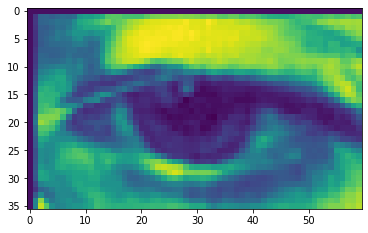

tf.Tensor([ 0.17673714 -0.1474674   0.97314817], shape=(3,), dtype=float32)


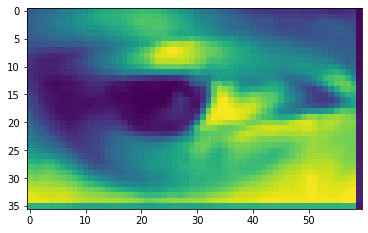

tf.Tensor([ 0.3543376  -0.24922037  0.9012958 ], shape=(3,), dtype=float32)


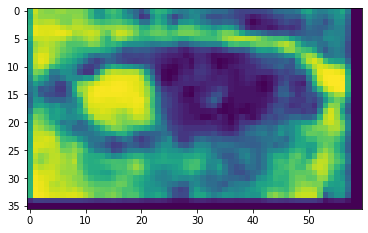

tf.Tensor([-0.12032501 -0.5105896   0.85136366], shape=(3,), dtype=float32)


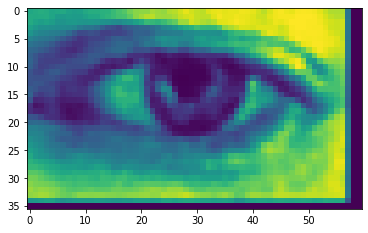

tf.Tensor([-0.37952363 -0.28891703  0.87891334], shape=(3,), dtype=float32)


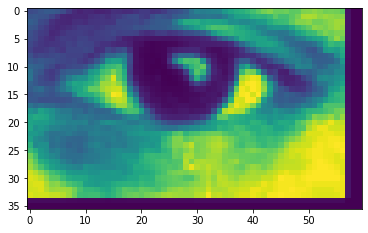

tf.Tensor([-0.1951867  -0.02936306  0.9803265 ], shape=(3,), dtype=float32)


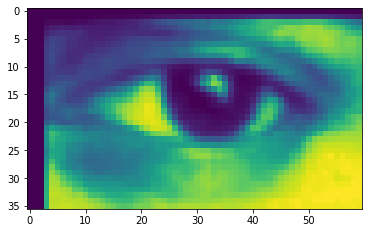

tf.Tensor([-0.13741717  0.10342754  0.98509854], shape=(3,), dtype=float32)


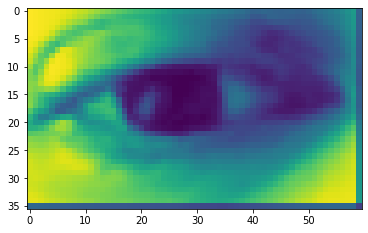

tf.Tensor([ 0.1630753  -0.50013006  0.85045654], shape=(3,), dtype=float32)


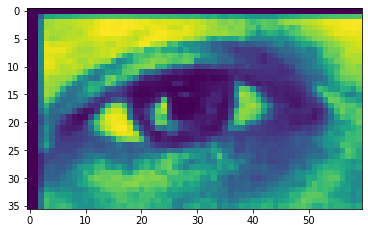

tf.Tensor([ 0.20124473 -0.43630973  0.8770031 ], shape=(3,), dtype=float32)


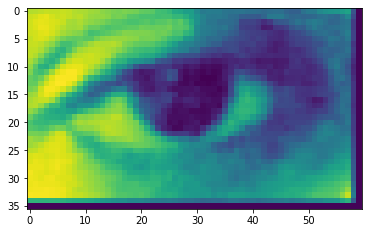

tf.Tensor([ 0.1046292  -0.2975997   0.94894004], shape=(3,), dtype=float32)


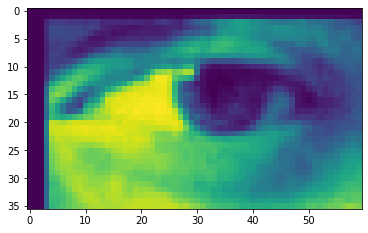

tf.Tensor([-0.37734485 -0.12790078  0.917198  ], shape=(3,), dtype=float32)


In [6]:
for a, b in train_dataset.take(10):
    plt.imshow(np.array(a[0]).reshape(36, 60))
    plt.show()
    print(b[0])

In [25]:
import sys
sys.path.append("watcher/")
import model as model_generator
import importlib
importlib.reload(model_generator)
model = model_generator.get_model()



"""with tf.GradientTape() as tape:
    values = model(pics[:32], training=True)
    loss_value = pixel_loss(values, coords_1[0:32])
    print(loss_value)"""

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 36, 60, 1)]  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 1500)         904650      input_6[0][0]                    
__________________________________________________________________________________________________
flatten_11 (Flatten)            (None, 2160)         0           input_6[0][0]                    
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 3660)         0           sequential_5[1][0]               
                                                                 flatten_11[0][0]           

'with tf.GradientTape() as tape:\n    values = model(pics[:32], training=True)\n    loss_value = pixel_loss(values, coords_1[0:32])\n    print(loss_value)'

In [ ]:
class my_callback(tf.keras.callbacks.Callback):
    def on_batch_end(self, batch, logs={}):
        if(tf.math.is_nan(logs['loss'])):
            tf.print(batch)
            self.model.stop_training = True
model.compile(
    optimizer=tf.keras.optimizers.Adam(clipnorm=1.), 
    loss=tf.keras.losses.CosineSimilarity())#pixel_loss)
NUM_EPOCHS = 10
clb = my_callback()
model.fit(train_dataset,
          epochs=NUM_EPOCHS,
          validation_data=test_dataset,
          validation_steps=int(len(data) / 5 / NUM_EPOCHS / NUM_BATCHES) - 2,
          callbacks=[tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint_path/",
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True),
                    clb]
         )

Epoch 1/10
  10678/Unknown - 552s 52ms/step - loss: -0.9882
Epoch 00001: val_loss improved from inf to -0.98192, saving model to checkpoint_path/
10678/10678 [==============================] - 564s 53ms/step - loss: -0.9882 - val_loss: 0.0000e+00
Epoch 2/10
10677/10678 [============================>.] - ETA: 0s - loss: -0.9886
Epoch 00002: val_loss did not improve from -0.98192
10678/10678 [==============================] - 552s 52ms/step - loss: -0.9886 - val_loss: -0.9818
Epoch 3/10
10677/10678 [============================>.] - ETA: 0s - loss: -0.9890
Epoch 00003: val_loss improved from -0.98192 to -0.98220, saving model to checkpoint_path/
10678/10678 [==============================] - 551s 52ms/step - loss: -0.9890 - val_loss: -0.9822
Epoch 4/10
10677/10678 [============================>.] - ETA: 0s - loss: -0.9893
Epoch 00004: val_loss did not improve from -0.98220
10678/10678 [==============================] - 553s 52ms/step - loss: -0.9893 - val_loss: -0.9821
Epoch 5/10
 1939/1

float64
<class 'numpy.ndarray'>


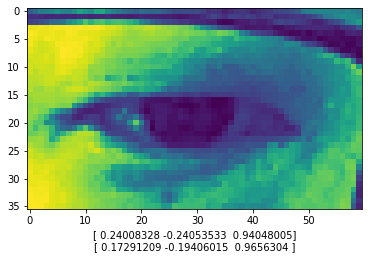

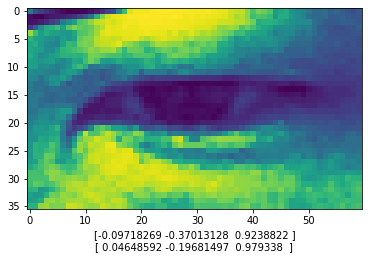

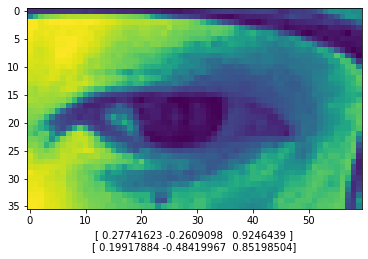

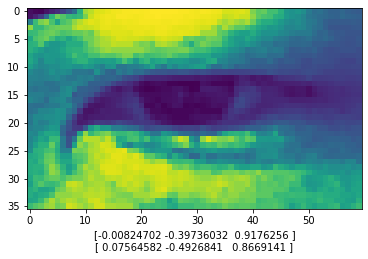

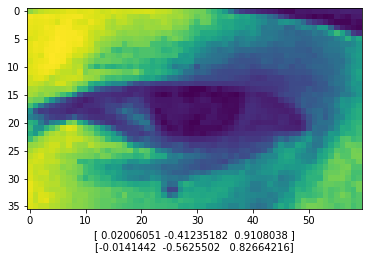

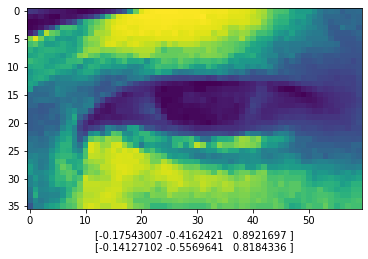

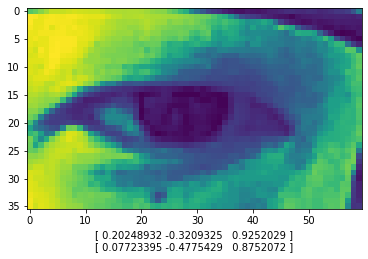

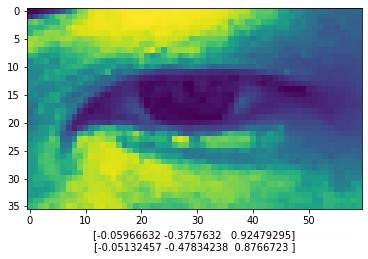

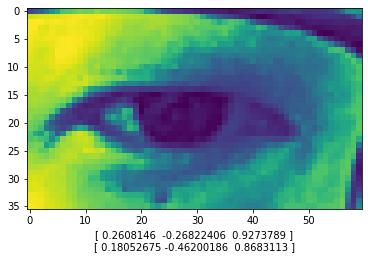

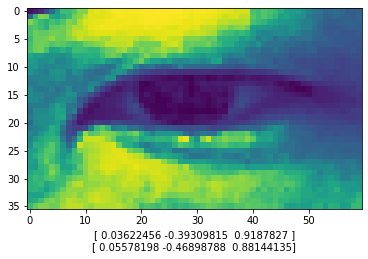

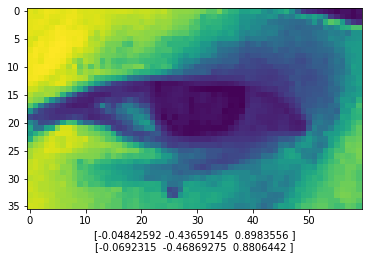

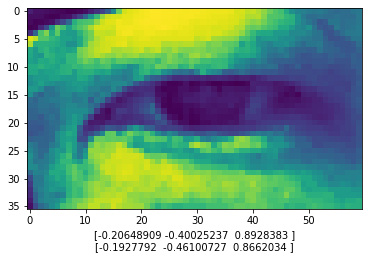

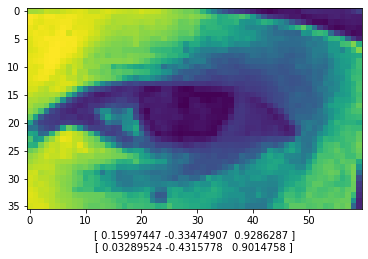

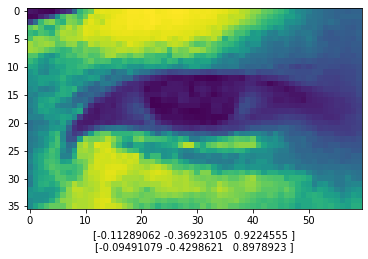

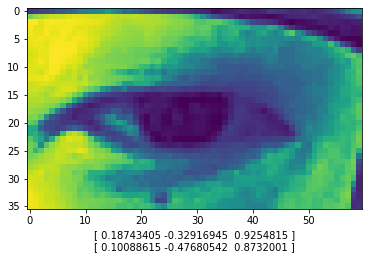

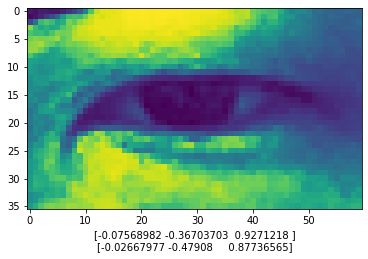

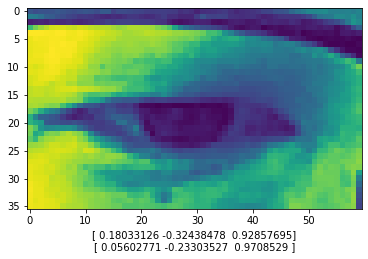

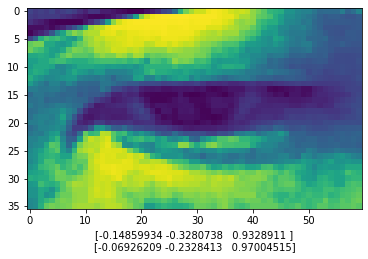

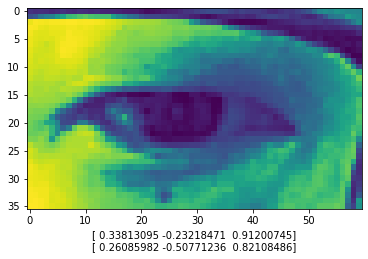

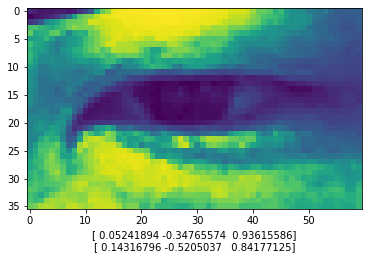

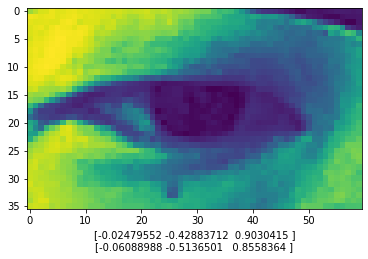

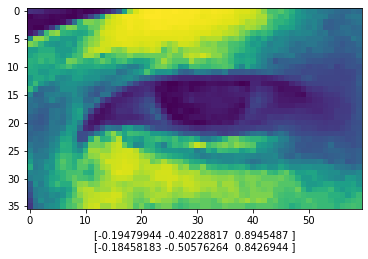

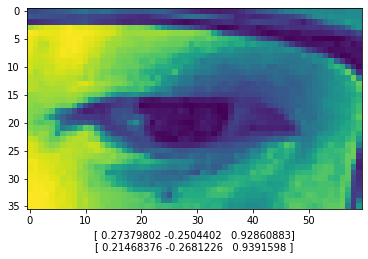

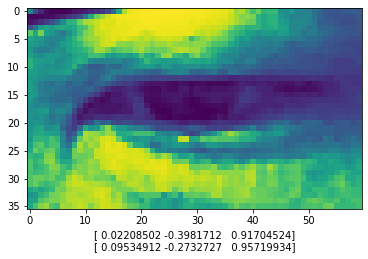

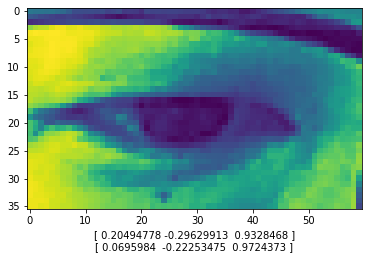

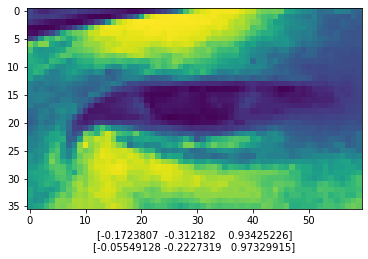

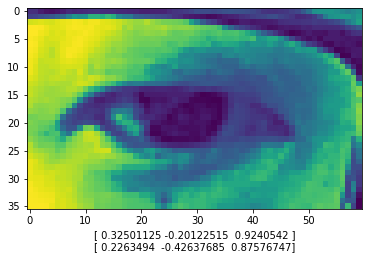

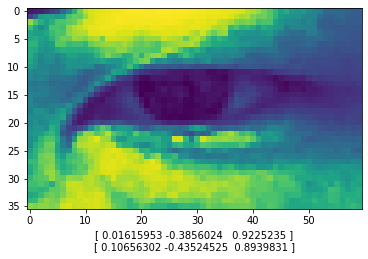

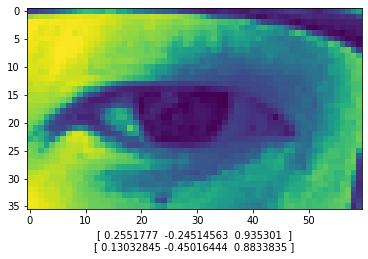

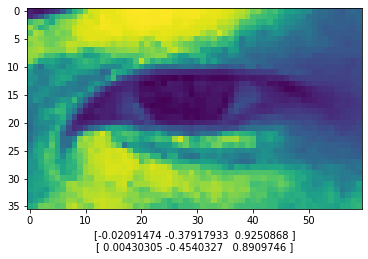

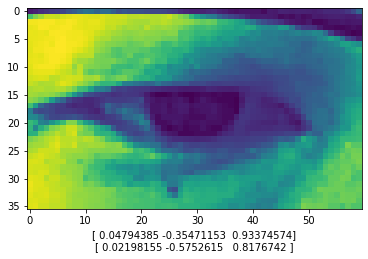

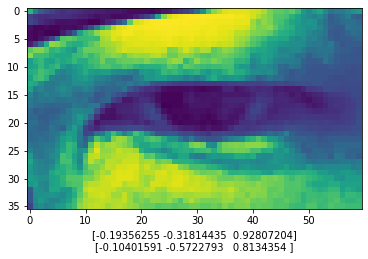

In [24]:
print(train_data.dtype)
predictions = model.predict(test_data[:32])
print(type(predictions))
for i in range(32):
    plt.xlabel(F'{predictions[i] / np.linalg.norm(predictions[i])}\n{test_labels[i]}')
    plt.imshow(test_data[i].reshape(36, 60))
    plt.show()

In [11]:
with tf.GradientTape() as tame:
    nums = model(train_data[:10], training=False)
    print(model.weights)
model.load_weights("checkpoint_path/")


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 60) dtype=float32, numpy=
array([[[[           nan,            nan,            nan,
                     nan,            nan,            nan,
                     nan,            nan,            nan,
                     nan,            nan,            nan,
                     nan,            nan,            nan,
                     nan,            nan,            nan,
                     nan,            nan,            nan,
                     nan,   